In [16]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd

In [2]:
model_name = "MODEL1mx60.h5"
model = load_model(model_name)

In [4]:
def load_images(lendata):
    images = []
    for i in range(1, lendata//60):
        img_path = rf'gaf_test\minute_gaf_block_{i}.png'
        img = cv2.imread(img_path)
        if img is None:
            print(f"Image not found: {img_path}")
            continue
        img = np.reshape(img, (1,60,60,3))
        images.append(img)
        
    return np.array(images)/255.0

images = load_images(70200)

images.shape


(1169, 1, 60, 60, 3)

In [8]:
def predict_all(images):
    predictions = [model.predict(i)[0] for i in images]
    # predictions = model.predict(images)
    results = []
    for prediction in predictions:
        if prediction[0] == max(prediction):
            results.append(1)
        elif prediction[1] == max(prediction):
            results.append(0)
        elif prediction[2] == max(prediction):
            results.append(-1)
    return results

# images = np.expand_dims(images, axis=-1)

predictions = predict_all(images)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

In [31]:
predict(120)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


-1

In [13]:
class MACD:
    def compute(self, data, short_window=12, long_window=26, signal_window=9):

        data['ema_short'] = data['close'].ewm(span=short_window, adjust=False).mean()
        data['ema_long'] = data['close'].ewm(span=long_window, adjust=False).mean()

        data['macd'] = data['ema_short'] - data['ema_long']

        data['signal_line'] = data['macd'].ewm(span=signal_window + 3, adjust=False).mean()

        data['macd_histogram'] = data['macd'] - data['signal_line']

        return data

class ConservativeMACDStrategy:
    def __init__(self, data, histogram_threshold=0.1):
        self.data = data
        self.histogram_threshold = histogram_threshold
        self.signals = []

    def run(self):

        macd = MACD().compute(self.data)
        self.data = macd

        self.in_position = False

        for i in range(1, len(self.data)):

            if(i<=60):
                pred=0
            else:
                try:
                    pred = predictions[(i-1)//60]
                except Exception as e:
                    pred = 0
            
            if not self.in_position:

                if (self.data.iloc[i]['macd'] > self.data.iloc[i]['signal_line'] and 
                    self.data.iloc[i]['macd_histogram'] > self.histogram_threshold and pred==1):
                    self.signals.append(1)  # Buy
                    self.in_position = True
                else:
                    self.signals.append(0)
            else:

                if (self.data.iloc[i]['macd'] < self.data.iloc[i]['signal_line'] and 
                    self.data.iloc[i]['macd_histogram'] < -self.histogram_threshold and pred==-1):
                    self.signals.append(-1)  # Sell
                    self.in_position = False
                else:
                    self.signals.append(0)

    def get_signals(self):
        return self.signals


data = pd.read_csv('SPY 2023 Data till Sep23.xlsx - Sheet1.csv', parse_dates=['timestamp'], index_col='timestamp')


strategy = ConservativeMACDStrategy(data, histogram_threshold=0.2)
strategy.run()
signals = strategy.get_signals()

print("Signals Generated:", len([s for s in signals if s != 0]))



Signals Generated: 31


Net Returns: 27536.579999999958
Total Brokerage: 1550
Number of closed trades: 31
Benchmark Return (in rupees): 12040.19472574389
Max holding time: 1136
Avg Holding time: 37.61290322580645
Gross Profit: 29086.57999999995
Net Profit: 28311.57999999995
Max Dip: 0.727390000000014
Max DrawDown: 8.1990678663572


,entry,exit,type,pl,duration,drawdown,dip
0,314,1450,Long,10049.00,1136,8.199068,0.727390
1,2010,2011,Short,684.00,1,0.000000,0.000000
2,2339,2340,Long,2244.00,1,0.000000,0.000000
3,3581,3582,Short,588.00,1,0.000000,0.000000
4,3900,3901,Long,-252.00,1,0.244343,0.244343
5,8101,8102,Short,478.56,1,0.000000,0.000000
6,8167,8168,Long,-264.00,1,0.254644,0.254644
7,8972,8973,Short,285.00,1,0.000000,0.000000
8,9052,9053,Long,198.00,1,0.000000,0.000000
9,15213,15214,Short,156.00,1,0.000000,0.000000


,portfolio,PnL,Position
0,100000.0,0.0,0.0
1,100000.0,0.0,0.0
2,100000.0,0.0,0.0
3,100000.0,0.0,0.0
4,100000.0,0.0,0.0
5,100000.0,0.0,0.0
6,100000.0,0.0,0.0
7,100000.0,0.0,0.0
8,100000.0,0.0,0.0
9,100000.0,0.0,0.0


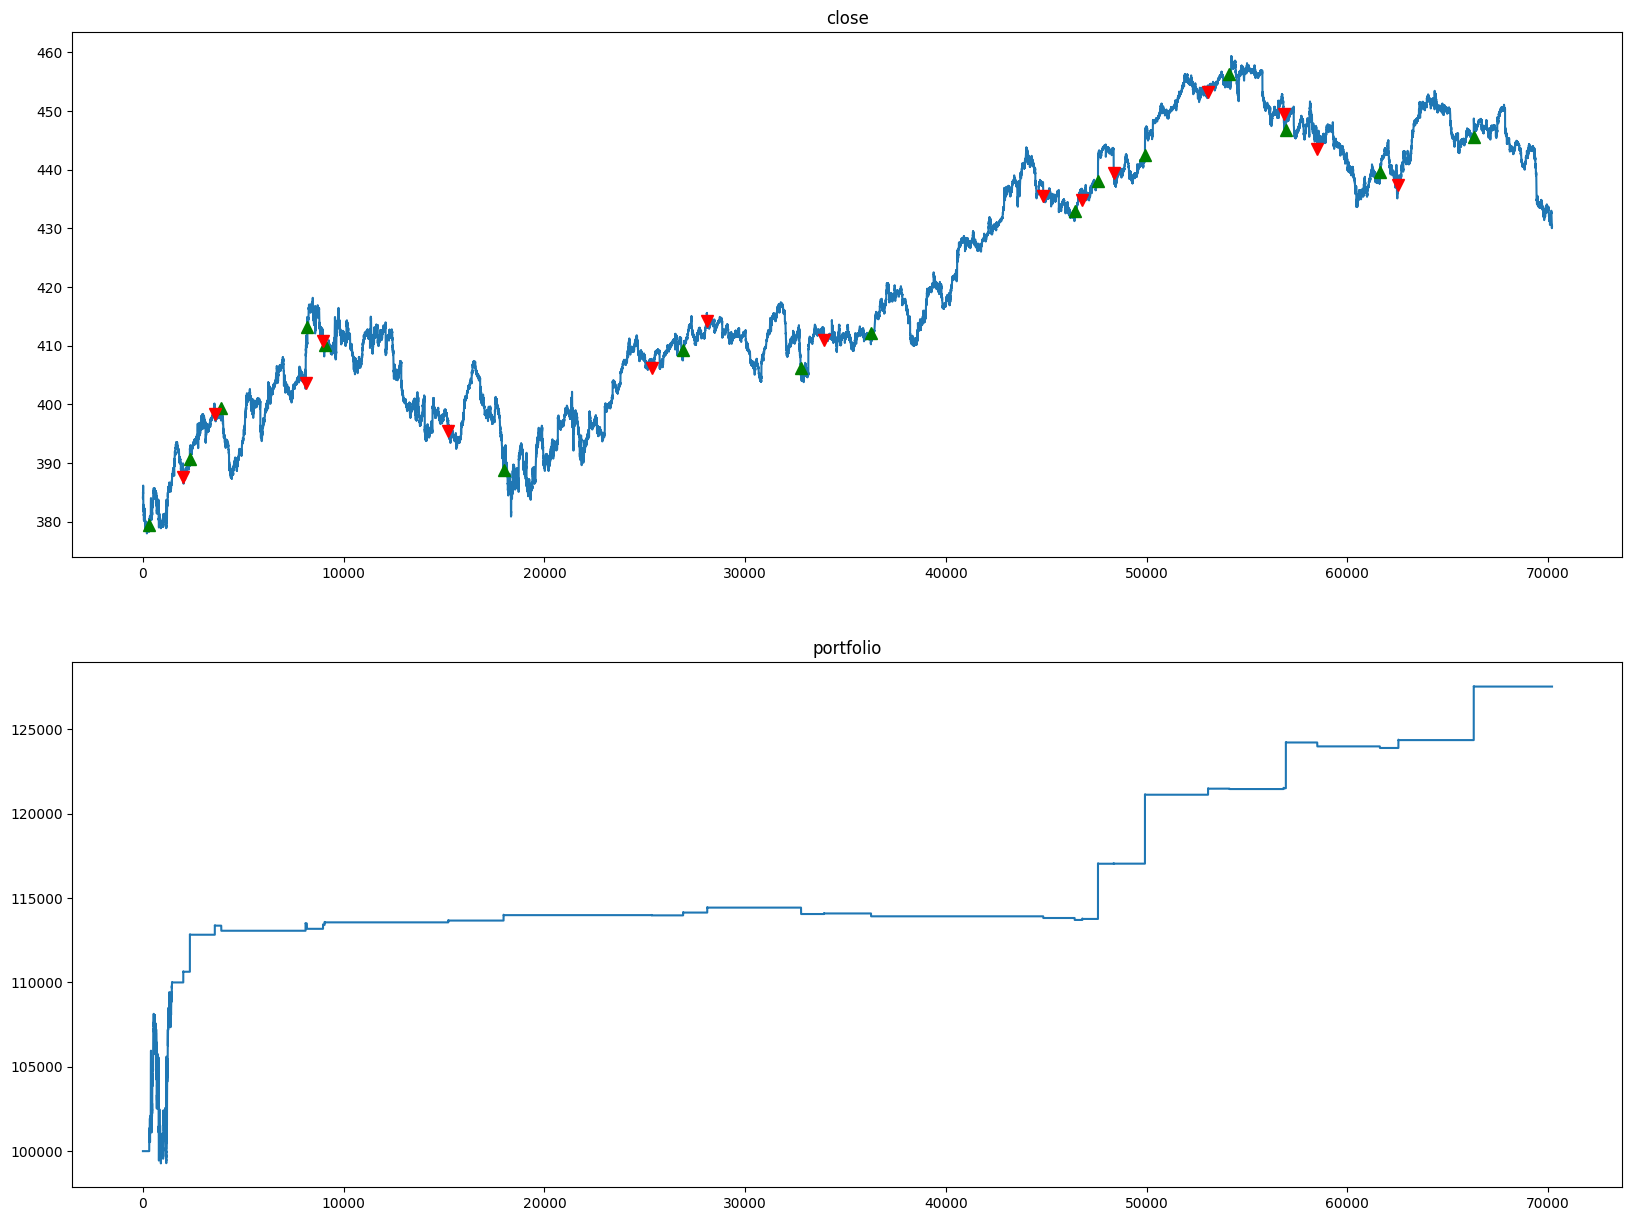

In [17]:
def backtest(close, stoploss, takeprofit, signalsarray, capital=100000, broker_charge=25, leverage=5):
    initialcap = capital
    current = 0
    portfolio = []
    stock = 0
    tradetype = []
    entryidx = []
    exitidx = []
    gprofitloss = []
    nprofitloss = []
    dailypnl = []
    dailyposn = []
    total_brokerage = 0

    max_trade_value = capital * leverage

    # Initialize the drawdown and dip lists
    drawdownl = []
    dipl = []

    # Ensure signalsarray matches the length of close
    if len(signalsarray) < len(close):
        signalsarray = np.pad(signalsarray, (0, len(close) - len(signalsarray)), 'constant')
    elif len(signalsarray) > len(close):
        signalsarray = signalsarray[:len(close)]

    for i in range(len(close)):
        if current == 0:
            dailypnl.append(0)
        elif current == 1:
            dailypnl.append(stock * (close[i] - close[i-1]))
        elif current == -1:
            dailypnl.append(stock * (close[i-1] - close[i]))
        dailyposn.append(current * stock)

        signal = signalsarray[i]

        if current == 0:
            portfolio.append(capital)

            if signal == 1:  # Buy signal
                entryidx.append(i)
                tradetype.append("Long")
                trade_value = min(capital * leverage, max_trade_value)  # Cap trade value to avoid excessive growth
                stock = trade_value / close[i]
                excess = stock % 100
                stock -= excess  # trade in 100 lots
                capital -= stock * close[i]

                # Brokerage for the buy side of the trade
                brokerage =  broker_charge  # Full brokerage charge since it's a round trip
                capital -= brokerage
                total_brokerage += brokerage

                current = 1

            elif signal == -1:  # Sell signal
                entryidx.append(i)
                tradetype.append("Short")
                trade_value = min(capital * leverage, max_trade_value)  # Cap trade value to avoid excessive growth
                stock = trade_value / close[i]
                excess = stock % 100
                stock -= excess
                capital += stock * close[i]

                # Brokerage for the sell side of the trade
                brokerage =  broker_charge  # Full brokerage charge since it's a round trip
                capital -= brokerage
                total_brokerage += brokerage

                current = -1

        elif current == 1:
            portfolio_value = stock * close[i] + capital
            portfolio.append(portfolio_value)

            if signal == -1 or (takeprofit > 0 and portfolio_value >= initialcap * (1 + takeprofit)):
                exitidx.append(i)
                capital += stock * close[i]
                # Brokerage for the sell side of the trade (closing long position)
                brokerage =  broker_charge  # Full brokerage charge since it's a round trip
                capital -= brokerage
                total_brokerage += brokerage
                gprofitloss.append(stock * (close[i] - close[entryidx[-1]]))
                nprofitloss.append(gprofitloss[-1] - brokerage)
                current = 0
                stock = 0

        elif current == -1:
            portfolio_value = capital + stock * (-close[i])
            portfolio.append(portfolio_value)

            if signal == 1 or (takeprofit > 0 and portfolio_value >= initialcap * (1 + takeprofit)):
                exitidx.append(i)
                capital -= stock * close[i]
                # Brokerage for the buy side of the trade (closing short position)
                brokerage =  broker_charge  # Full brokerage charge since it's a round trip
                capital -= brokerage
                total_brokerage += brokerage
                gprofitloss.append(stock * (close[entryidx[-1]] - close[i]))
                nprofitloss.append(gprofitloss[-1] - brokerage)
                current = 0
                stock = 0

    if current != 0:
        portfolio = portfolio[:entryidx[-1]] + (len(close) - entryidx[-1]) * [portfolio[entryidx[-1]-1]]
        tradetype.pop()
        entryidx.pop()

    tradedf = pd.DataFrame({"entry": entryidx, "exit": exitidx, "type": tradetype, "pl": gprofitloss})
    tradedf["duration"] = tradedf.exit - tradedf.entry

    dailydf = pd.DataFrame({"portfolio": portfolio, "PnL": dailypnl, "Position": dailyposn})
    
    # Check if trades were executed
    if not gprofitloss:
        print("No trades were executed.")
        return portfolio
    
    print("Net Returns:", portfolio[-1] - initialcap)
    print("Total Brokerage:", total_brokerage)
    print("Number of closed trades:", len(entryidx))
    print("Benchmark Return (in rupees):", initialcap * (close[-1] - close[0]) / close[0])
    print("Max holding time:", np.max(tradedf['duration']))
    print("Avg Holding time:", np.mean(tradedf['duration']))
    print("Gross Profit:", sum(gprofitloss))
    print("Net Profit:", sum(nprofitloss))

    for i in range(len(entryidx)):
        ini = portfolio[entryidx[i]]
        maxx = portfolio[entryidx[i]]
        minn = portfolio[entryidx[i]]
        maxdd = 0

        for j in range(entryidx[i], exitidx[i]+1):
            if portfolio[j] >= maxx:
                maxx = portfolio[j]
            if portfolio[j] < maxx:
                drawd = (maxx - portfolio[j]) * 100 / maxx
                maxdd = max(maxdd, drawd)
            minn = min(portfolio[j], minn)
        
        drawdownl.append(maxdd)
        dipl.append((ini - minn) / ini * 100)
    
    print("Max Dip:", max(dipl))
    print("Max DrawDown:", max(drawdownl))

    tradedf['drawdown'] = drawdownl
    tradedf['dip'] = dipl
    display(tradedf)
    display(dailydf.head(50))
        
    f, axarr = plt.subplots(2, figsize=(20,15))
    axarr[0].plot([i for i in range(len(close))],close)
    axarr[0].set_title('close')

    axarr[0].plot([i for i in entryidx + exitidx if signalsarray[i] == 1], close[[i for i in entryidx + exitidx if signalsarray[i] == 1]], '^', markersize=8, color='g', label='Buy Signal', linewidth=1)
    axarr[0].plot([i for i in entryidx + exitidx if signalsarray[i] == -1], close[[i for i in entryidx + exitidx if signalsarray[i] == -1]], 'v', markersize=8, color='r', label='Sell Signal', linewidth=1)

    axarr[1].plot(portfolio)
    axarr[1].set_title('portfolio')
    
    return portfolio

# Example usage
backtestedportfolio = backtest(data['close'], 0.05, 0.1, signals, leverage=5)


In [5]:
images[0].shape

(1, 60, 60, 3)